In [2]:
import os
import glob
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import scipy

In [195]:
tf.random.set_seed(42)
files = glob.glob(os.path.join('train/', '*/*'))
stars = []
for file in files:
    file_name = file.split('\\')[1]
    stars.append(file_name)
stars = np.unique(stars)

import random
random.seed(42)

def split_star_list(file_list, test_ratio=0.6):
    random.shuffle(file_list)
    split_index = int(len(file_list) * (1 - test_ratio))
    train_files = file_list[:split_index]
    test_files = file_list[split_index:]
    return train_files, test_files

train_stars, test_stars = split_star_list(stars)

labelDf = pd.read_csv("train_labels.csv")
labelDf = labelDf.set_index('planet_id')
meanLabels = np.mean(labelDf.mean())
stdLabels = np.std(labelDf.std())
maxLabels = np.max(labelDf.max())
minLabels = np.min(labelDf.min())

trainLabels = labelDf.loc[[int(star) for star in train_stars]]
meanTrainLabels = np.mean(trainLabels.mean())
stdTrainLabels = np.std(trainLabels.std())
maxTrainLabels = np.max(trainLabels.max())
minTrainLabels = np.min(trainLabels.min())

for col in labelDf.columns:
    labelDf.loc[:,col] = (labelDf[col]) / (maxTrainLabels)

# normalize over time and all samples, so we have a mean and a std dev per wavelength for all samples
def calcMeanAndStdOfTrain(train_stars):
    i = 0
    for star in train_stars:
        file_path = 'train/'+str(star)+'/combined.npz'
        with np.load(file_path) as data:
            x = data['a'][0,:,0:283,:]
            if i ==0:
                mean = np.mean(x,axis=(0))
                sumS = np.sum(x**2,axis=0)
            else:
                mean = mean + np.mean(x, axis=(0))
                sumS += np.sum(x**2,axis=0)
            i=i+1
    meanTrain = mean / i
    stdTrain = np.sqrt(sumS / (i*x.shape[0]) - meanTrain**2)    
    return meanTrain, stdTrain
meanTrain, stdTrain = calcMeanAndStdOfTrain(train_stars)

def normalize_over_train(features, labels):
    #features = (features - meanTrain) / (stdTrain + 1e-6)
    features = (features - meanTrain) / (stdTrain + 1e-6)
    return features, labels

# normalize over time per samples, so we have a mean and a std dev per wavelength for all samples
def calcMeanAndStdOfTrainPerStar(x):
    mean = np.mean(x,axis=(0))
    sumS = np.sum(x**2,axis=0)
    stdTrain = np.sqrt(sumS / (x.shape[0]) - mean**2)    
    return mean, stdTrain
def normalize_per_sample(features, labels):
    m,s = calcMeanAndStdOfTrainPerStar(features)
    features = (features) / (s + 1e-6)
    return features, labels




def load_npz(star):
    integer_value = tf.strings.to_number(star, out_type=tf.int64)
    python_int = integer_value.numpy()

    file_path = 'train/'+str(python_int)+'/combined.npz'
    try:
        with np.load(file_path) as data:
            features = data['a'][0,:,0:283,:]
            labels = np.reshape(np.mean(labelDf.loc[python_int].to_numpy()),(1))
            features = np.reshape(features,(-1,25,283,4))
            features = np.mean(features,axis=1)
            #features, labels = normalize_per_sample(features,labels)
            features, labels = normalize_over_train(features,labels)
            return features, labels
    except Exception as e:
        print("Error loading file:", e, python_int)


def create_dataset(star_list, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(star_list)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(star_list))
    def load_and_process(x):
        features, labels = tf.py_function(
            func=load_npz,
            inp=[x],
            Tout=[tf.float64, tf.float32]
        )
        return features, labels

    dataset = dataset.map(load_and_process, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda x, y: (tf.ensure_shape(x,tf.TensorShape([225, 283, 4])), tf.ensure_shape(y, tf.TensorShape(1)))) #5625
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [196]:
tf.random.set_seed(42)
batch_size = 4

train_dataset = create_dataset(train_stars, batch_size, shuffle=True)
test_dataset = create_dataset(test_stars, batch_size, shuffle=False)

In [183]:
for x,y in train_dataset:
    print(x.shape, y.shape)
    break

(4, 225, 283, 4) (4, 1)


# model

In [203]:
timepoints = 225
representations = 4
wavelengths = 283
targetWavelengths = 283

class meanOfWavelengths(tf.keras.layers.Layer):
    def __init__(self, concat=True,**kwargs):
        self.concat=concat
        super().__init__(**kwargs)
    def call(self, x):
        m = tf.expand_dims(tf.reduce_mean(x,axis=-1),axis=-1)
        x = tf.concat([x,m],axis=-1)
        max = tf.reduce_max(m,axis=-2,keepdims=True)
        m = m/max
        return x if self.concat else m

def cnnMConverges(outputDim = 283):
    inp = tf.keras.Input(shape=(timepoints, wavelengths, representations))
    x = inp[:,:,:,1]    
    print(x)
    x = meanOfWavelengths(False)(x)
    
    #x = Reshape11()(x)
    #dim = timepoints
    for i in range(3):
        # convolution with n_wavelengths of channels -> applying same operation across all channels
        # after first convolution we have timepoints*wavelengths -> timepoints*284 filter outputs (* 1 channel)

        # depth multiplier is literally multiplying the input, doesn't make sense
        #x = tf.keras.layers.DepthwiseConv1D(kernel_size=10,strides=1,padding='valid', depth_multiplier=4,activation='relu')(x) 

        x = tf.keras.layers.Conv1D(filters=4*(i+1), kernel_size=(50), padding='valid')(x)
    #    #x = tf.keras.layers.Dense(283)(x)
        #x = tf.keras.layers.AveragePooling1D(2)(x)
#
    #x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.Dense(100,activation='relu')(x)
    #x = tf.keras.layers.Dense(50,activation='relu')(x)
    x = tf.keras.layers.Dense(1,activation='linear')(x)

    model = tf.keras.Model(inp, x)
    return model

def cnnMconverges2(outputDim = 283):
    inp = tf.keras.Input(shape=(timepoints, wavelengths, representations))
    x = inp[:,:,:,1]    
    print(x)
    x = meanOfWavelengths(False)(x)
    
    #x = Reshape11()(x)
    #dim = timepoints
    for i in range(3*5):
        # convolution with n_wavelengths of channels -> applying same operation across all channels
        # after first convolution we have timepoints*wavelengths -> timepoints*284 filter outputs (* 1 channel)

        # depth multiplier is literally multiplying the input, doesn't make sense
        #x = tf.keras.layers.DepthwiseConv1D(kernel_size=10,strides=1,padding='valid', depth_multiplier=4,activation='relu')(x) 

        x = tf.keras.layers.Conv1D(filters=8, kernel_size=(10), padding='valid')(x)
    #    #x = tf.keras.layers.Dense(283)(x)
        #x = tf.keras.layers.AveragePooling1D(2)(x)
#
    #x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.Dense(100,activation='relu')(x)
    #x = tf.keras.layers.Dense(50,activation='relu')(x)
    x = tf.keras.layers.Dense(1,activation='linear')(x)

    model = tf.keras.Model(inp, x)
    return model

#also converges, although slower and not as good
def cnnMconv3(outputDim = 283):
    inp = tf.keras.Input(shape=(timepoints, wavelengths, representations))
    x = inp[:,:,:,1]    
    print(x)
    x = meanOfWavelengths(False)(x)
    
    #x = Reshape11()(x)
    #dim = timepoints
    for i in range(3):
        # convolution with n_wavelengths of channels -> applying same operation across all channels
        # after first convolution we have timepoints*wavelengths -> timepoints*284 filter outputs (* 1 channel)

        # depth multiplier is literally multiplying the input, doesn't make sense
        #x = tf.keras.layers.DepthwiseConv1D(kernel_size=10,strides=1,padding='valid', depth_multiplier=4,activation='relu')(x) 

        x = tf.keras.layers.Conv1D(filters=8, kernel_size=(10), padding='valid')(x)
    #    #x = tf.keras.layers.Dense(283)(x)
        x = tf.keras.layers.AveragePooling1D(2)(x)
#
    #x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.Dense(100,activation='relu')(x)
    #x = tf.keras.layers.Dense(50,activation='relu')(x)
    x = tf.keras.layers.Dense(1,activation='linear')(x)

    model = tf.keras.Model(inp, x)
    return model

# with normalized data (no mean correction)
# with normalized data + mean offset -> converges
# with all inputs also converges (appending mean)
def cnnM(outputDim = 283):
    inp = tf.keras.Input(shape=(timepoints, wavelengths, representations))
    x = inp[:,:,:,1]    
    print(x)
    #x = meanOfWavelengths(True)(x)
    
    #x = Reshape11()(x)
    #dim = timepoints
    for i in range(3*2):
        # convolution with n_wavelengths of channels -> applying same operation across all channels
        # after first convolution we have timepoints*wavelengths -> timepoints*284 filter outputs (* 1 channel)

        # depth multiplier is literally multiplying the input, doesn't make sense
        #x = tf.keras.layers.DepthwiseConv1D(kernel_size=10,strides=1,padding='valid', depth_multiplier=1,activation='relu')(x) 

        x = tf.keras.layers.Conv1D(filters=8, kernel_size=(20), padding='valid')(x)
    #    #x = tf.keras.layers.Dense(283)(x)
        #x = tf.keras.layers.AveragePooling1D(2)(x)
#
    #x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.Flatten()(x)
    #x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.Dense(100,activation='relu')(x)
    #x = tf.keras.layers.Dense(50,activation='relu')(x)
    x = tf.keras.layers.Dense(1,activation='linear')(x)

    model = tf.keras.Model(inp, x)
    return model

model = cnnM() 
model.summary()

<KerasTensor shape=(None, 225, 283), dtype=float32, sparse=False, name=keras_tensor_514>


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_47 (InputLayer)     │ (None, 225, 283, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item_47 (GetItem)           │ (None, 225, 283)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_133 (Conv1D)             │ (None, 206, 8)         │        45,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_134 (Conv1D)             │ (None, 187, 8)         │         1,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_135 (Conv1D)             │ (None, 168, 8)         │         1,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_136 (Conv1D)             │ (None, 149, 8)         │         1,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_137 (Conv1D)             │ (None, 130, 8)         │         1,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_138 (Conv1D)             │ (None, 111, 8)         │         1,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_42 (Flatten)            │ (None, 888)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 100)            │        88,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,729 (549.72 KB)

 Trainable params: 140,729 (549.72 KB)

 Non-trainable params: 0 (0.00 B)

In [204]:
batch = next(iter(train_dataset))
out = model(batch[0])
test_batch = next(iter(test_dataset))
batch[0].dtype ,batch[1].dtype, out.dtype,batch[0].shape ,batch[1].shape, out.shape

(tf.float64,
 tf.float32,
 tf.float32,
 TensorShape([4, 225, 283, 4]),
 TensorShape([4, 1]),
 TensorShape([4, 1]))

In [205]:
tf.random.set_seed(42)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
model.compile(loss='mse'            
              #,metrics=[log_likelihood_maxScaling]
              ,metrics=['mae']
              , optimizer=optimizer)

history = model.fit(train_dataset, 
                    #batch[0],batch[1], #verbose=2,
                    validation_data=test_dataset,
                    #validation_data=(test_batch[0],test_batch[1]),
                    epochs=100, batch_size=batch_size,
                    #callbacks=[lr_callback]
                    )

Epoch 1/100


68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - loss: 15.1839 - mae: 2.4185 - val_loss: 0.0265 - val_mae: 0.1320
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 247ms/step - loss: 0.0409 - mae: 0.1596 - val_loss: 0.0238 - val_mae: 0.1160
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step - loss: 0.0270 - mae: 0.1240 - val_loss: 0.0254 - val_mae: 0.1276
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - loss: 0.0255 - mae: 0.1218 - val_loss: 0.0367 - val_mae: 0.1619
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - loss: 0.0433 - mae: 0.1597 - val_loss: 0.0254 - val_mae: 0.1271
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step - loss: 0.0303 - mae: 0.1412 - val_loss: 0.0312 - val_mae: 0.1448
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - loss: 0.0233 - mae: 0.1199 - val_loss: 0.0348 - val_mae: 0.1385
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - loss: 0.0230 - mae: 0.1113 - val_loss: 0.0239 - val_mae: 0.1204
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/st

In [ ]:
Epoch 32/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - loss: 4.6352e-04 - mae: 0.0150 - val_loss: 6.5369e-04 - val_mae: 0.0148


68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - loss: 6.8122e-04 - mae: 0.0140 - val_loss: 5.9214e-04 - val_mae: 0.0134

# investigate

In [177]:
pred = model.predict(test_batch[0])*maxTrainLabels
y =test_batch[1]*maxTrainLabels
pred,y

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


(array([[0.00129583],
        [0.00035366],
        [0.00096976],
        [0.00173627]], dtype=float32),
 <tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[0.00112978],
        [0.00045748],
        [0.00080496],
        [0.00177076]], dtype=float32)>)

In [178]:
np.sum((pred - y)**2) / pred.shape[0]

1.6675352654260678e-08

(1, 225, 283)
(1, 225, 1)


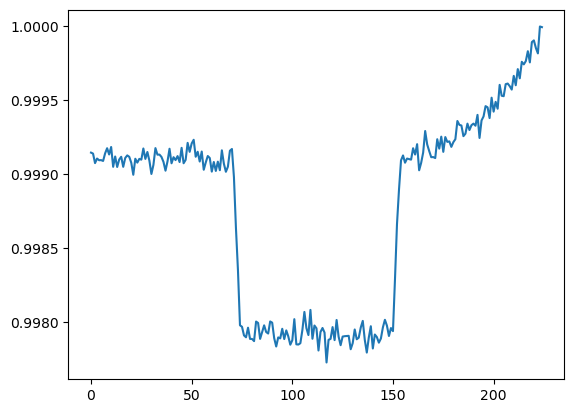

(1, 176, 4)


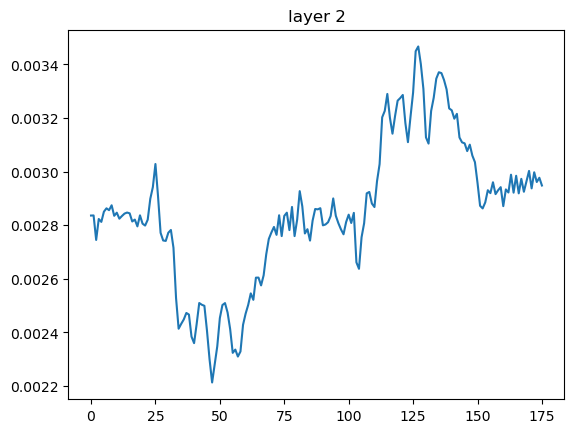

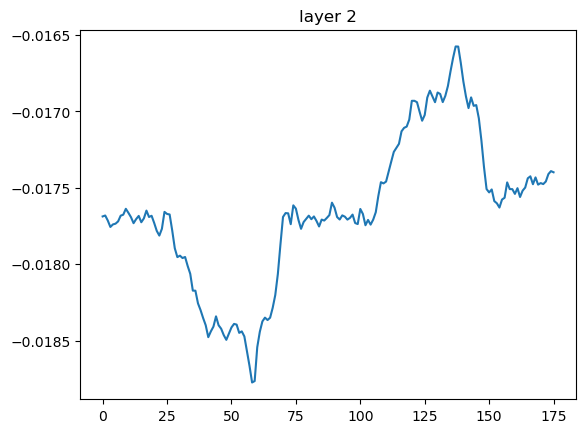

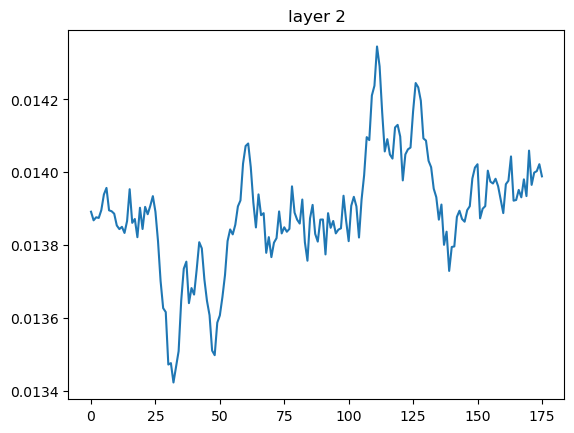

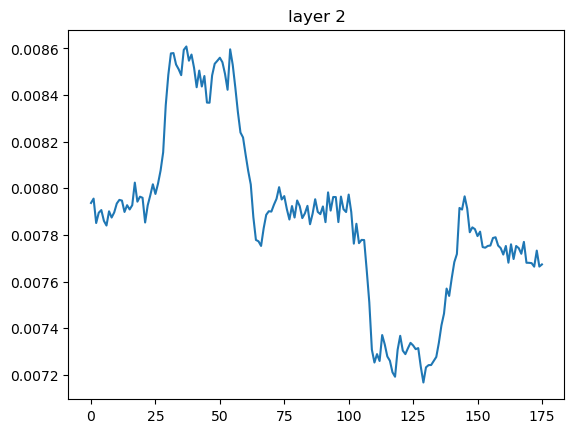

(1, 127, 8)


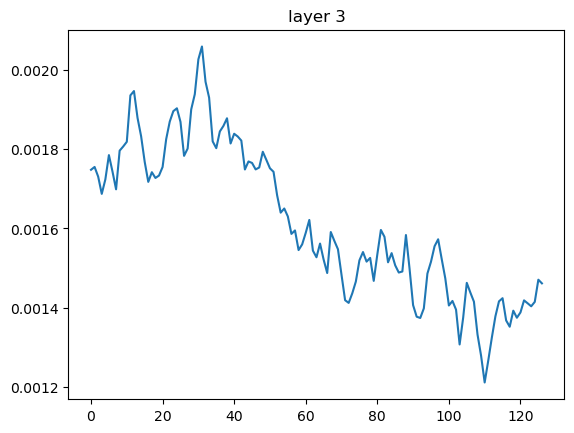

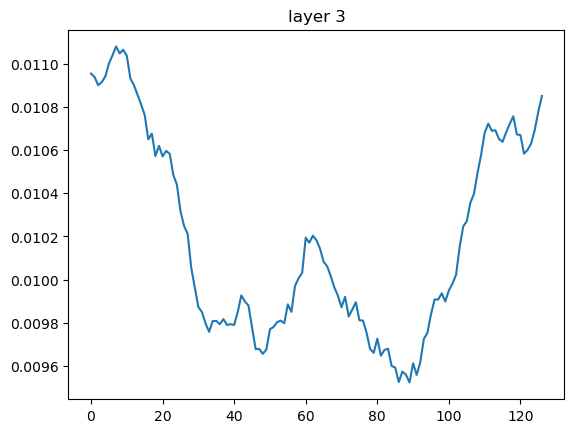

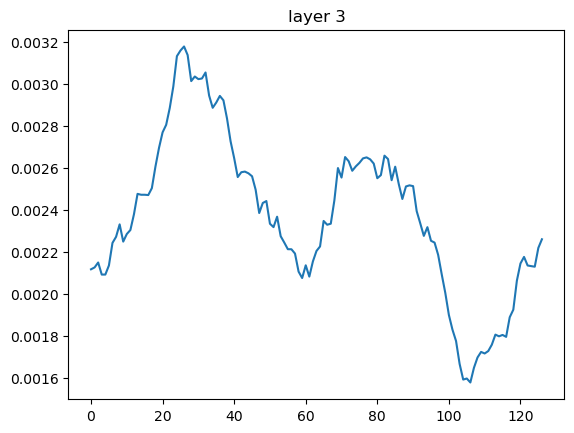

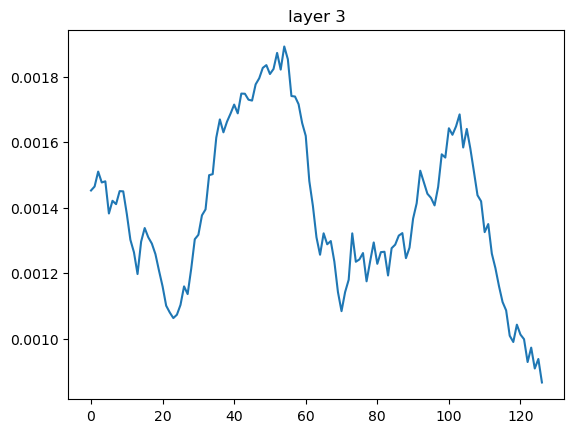

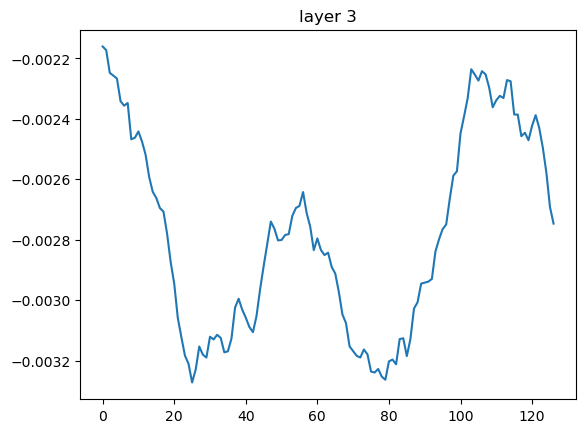

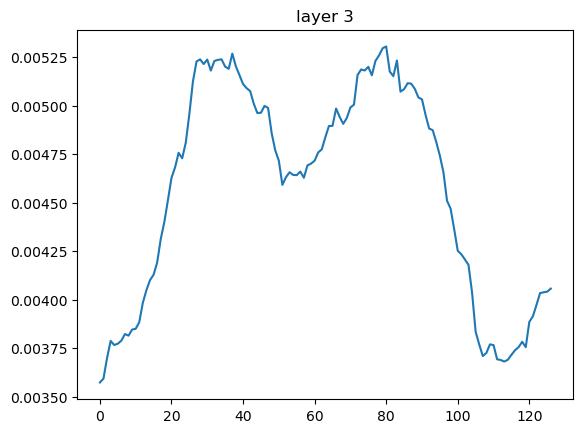

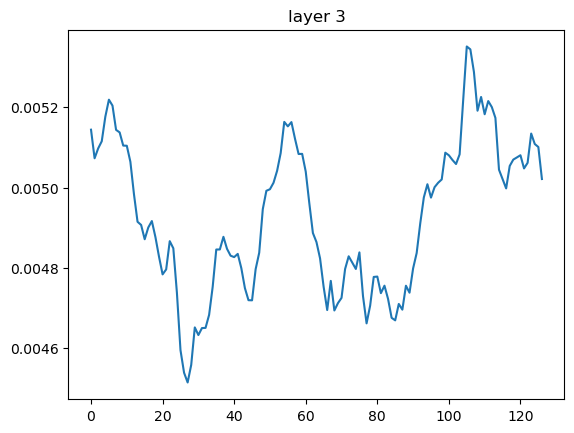

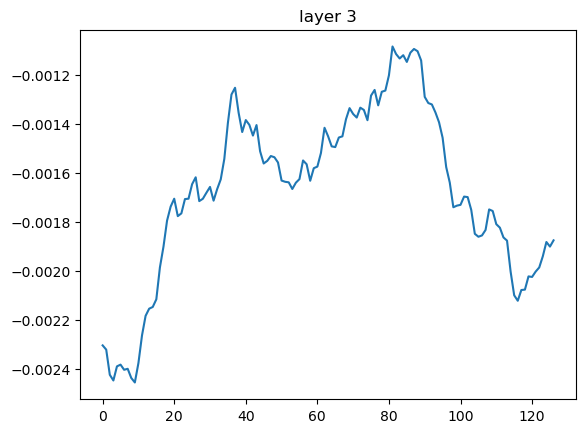

(1, 78, 12)


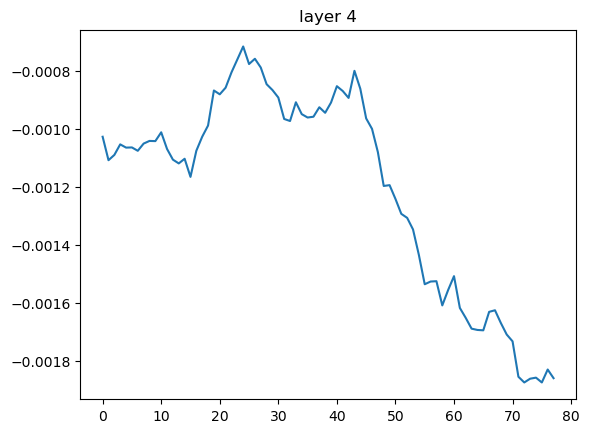

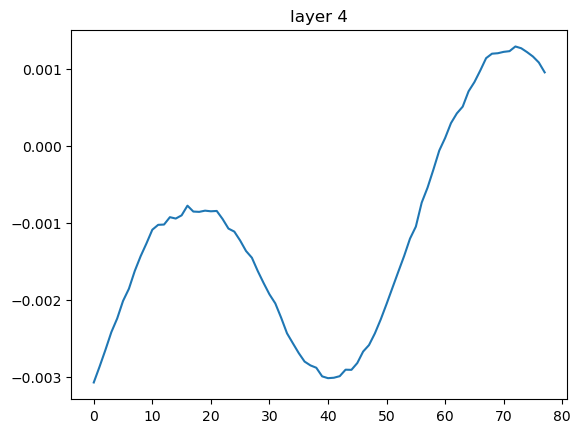

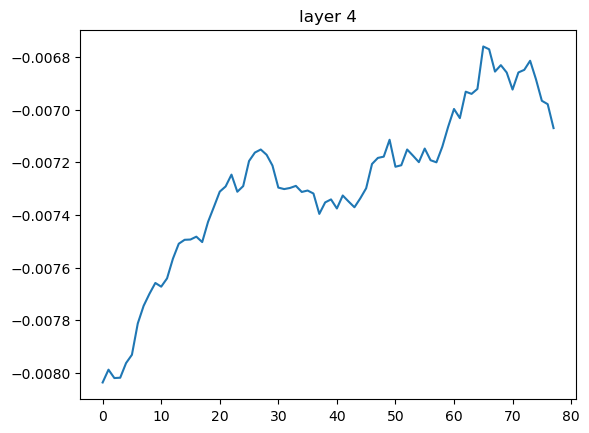

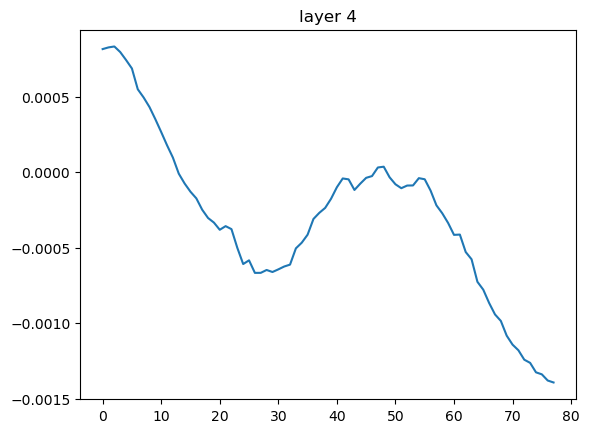

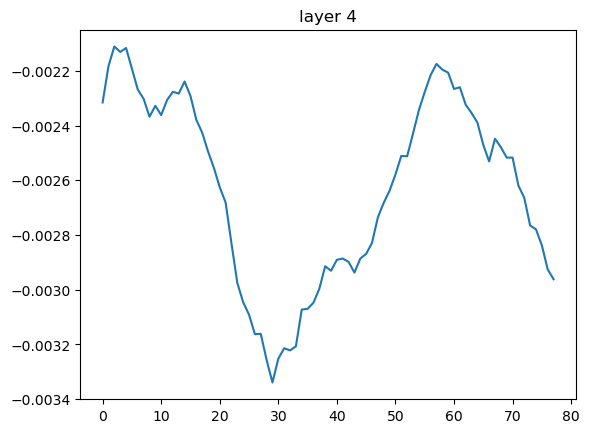

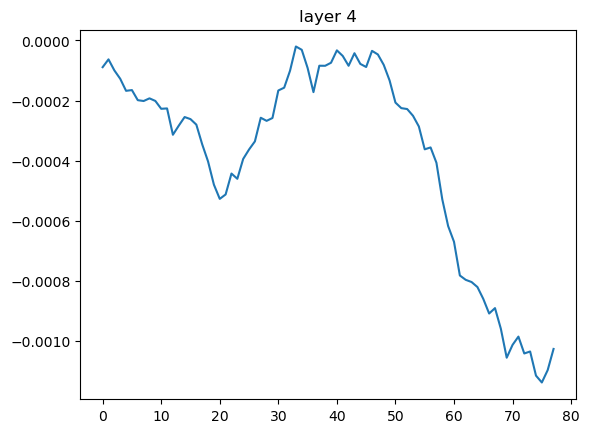

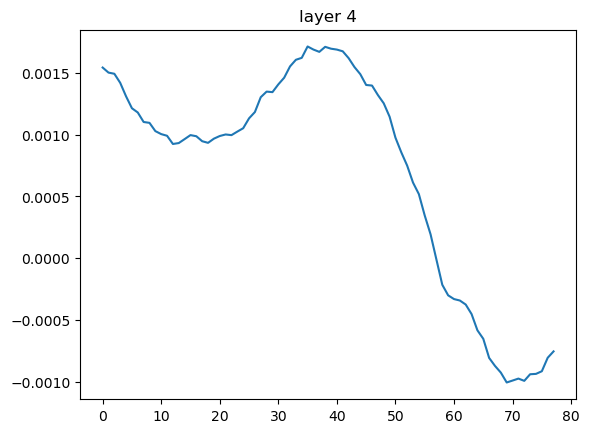

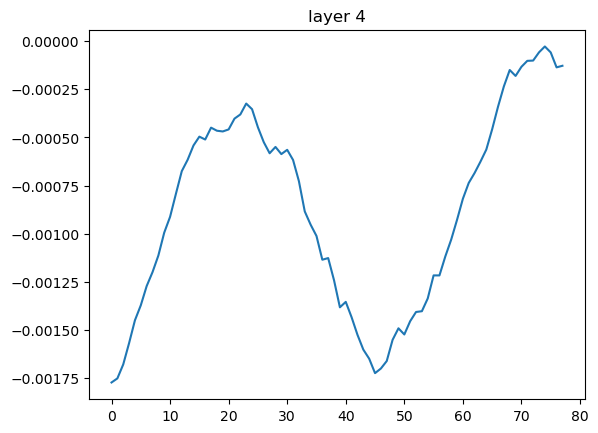

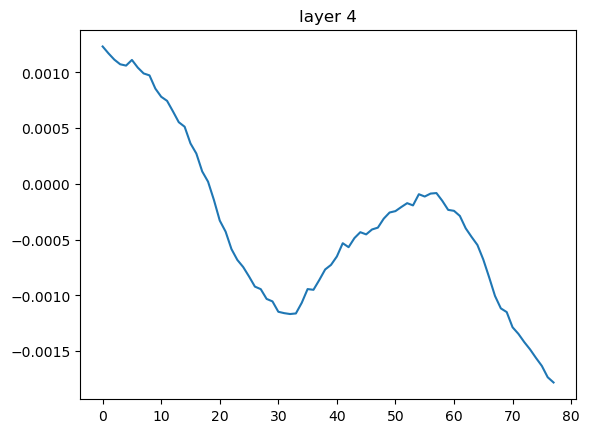

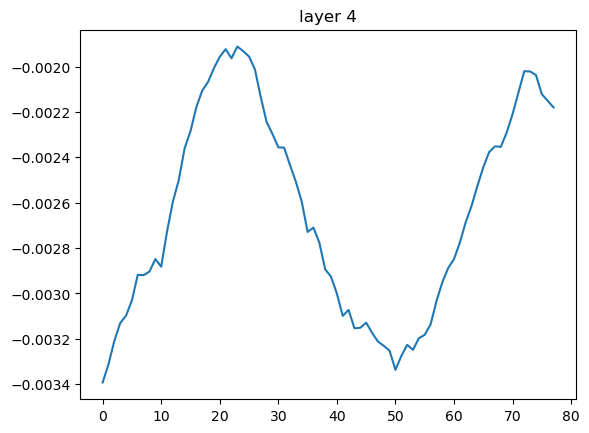

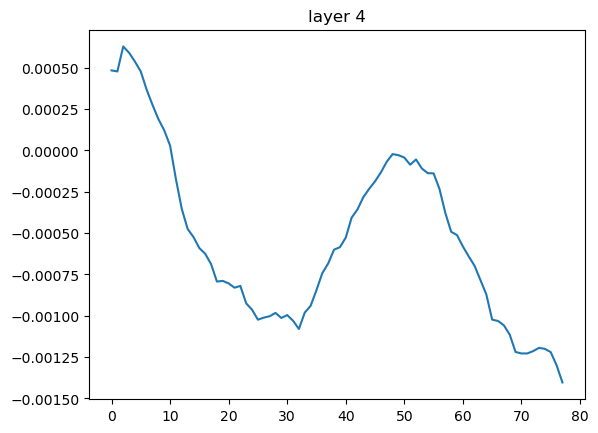

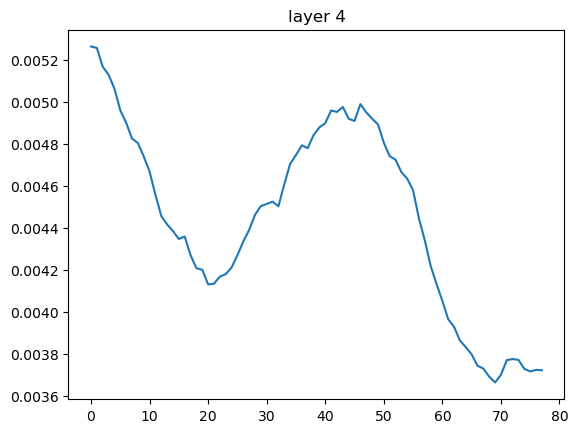

(1, 936)


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

<Figure size 640x480 with 0 Axes>

In [148]:
x = batch[0][0:1,:,:,1]    
print(x.shape)
x = model.layers[1](x)
print(x.shape)
fig1 = plt.figure()
plt.plot(x[0,:,0])
plt.show()

for layers in range(6):
    x = model.layers[2+layers](x)
    print(x.shape)
    
    for i in range(x.shape[-1]):
        fig = plt.figure()
        plt.plot(x[0,:,i])
        plt.title(f'layer {layers+2}')
        plt.show()
#print(model.layers[2].get_weights())

In [114]:
model.layers[2].get_weights()[0].shape

(10, 1, 4)

In [78]:
x = batch[0][:,:,:,1]    
print(x.shape)
x = meanOfWavelengths(False)(x)
m = tf.reduce_max(x,axis=-2,keepdims=True)
print(m.shape)
x = x / m
print(x.shape)

(4, 225, 283)
(4, 1, 1)
(4, 225, 1)


tf.Tensor(
[[0.23250966]
 [0.7439196 ]
 [0.18068464]
 [0.7506304 ]], shape=(4, 1), dtype=float32)


C:\Users\uic33116\AppData\Local\Temp\ipykernel_3740\374503013.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


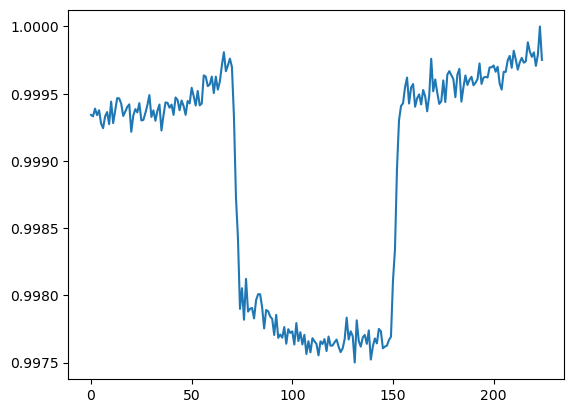

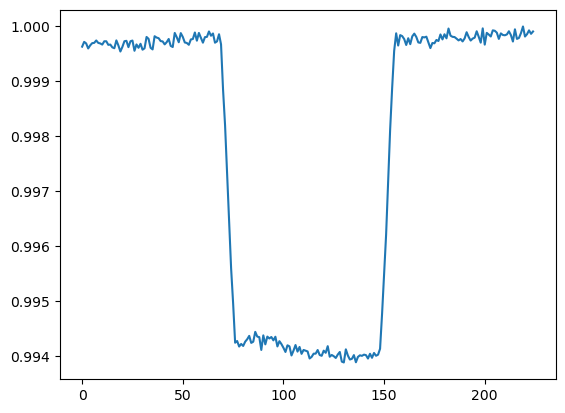

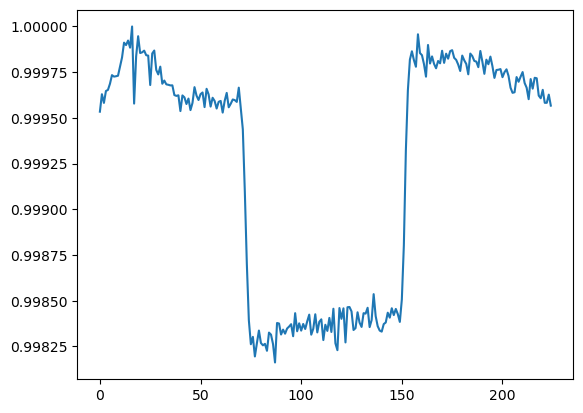

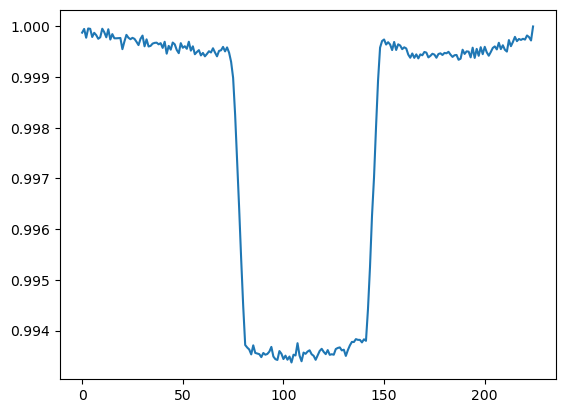

In [79]:
print(batch[1])
for i in range(4):
    fig=plt.figure()
    plt.plot(x[i,:,0])
    fig.show()